### CAPTURE SATELLITE IMAGES FOR PRESENT PERIOD (2017 - 2022)

In [9]:
import ee
import numpy as np
import matplotlib.pyplot as plt

Authentification auprès de Google Engine :

Cliquer sur le lien et suivre les instructions (avec compte google connecté) pour récupérer le token à copier-coller.

In [10]:
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())


Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


FUNCTIONS :

In [24]:
def NDVI(img): #repère la végétation tout simplement
    img = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return img

def EVI(img): #idem NDVI, plus fiable et fin en théorie
    img = ee.Image(img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('B8').divide(10000),
            'RED': img.select('B4').divide(10000),
            'BLUE': img.select('B2').divide(10000)
        })).rename(["evi"])
    
    return img

def NDMI(img): #repère la teneur en eau dans la végétation
    img = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndmi"])
    #img = ee.Image(img.expression(
    #    '(NIR - SWITCH) / (SWITCH + NIR)', {
    #        'NIR': img.select('B8').divide(10000),
    #        'SWITCH': img.select('B11').divide(10000)
    #   })).rename(["ndmi"])
    return img

def NDWI(img): #teneur en d'eau en surface
    img = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    #img = ee.Image(img.expression(
    #    '(GREEN - NIR) / (GREEN + NIR)', {
     #       'NIR': img.select('B8').divide(10000),
     #       'GREEN': img.select('B3').divide(10000)
     #   })).rename(["ndwi"])
    return img


def PSSra(img): #indice de pigmentation de la végétation
    img = ee.Image(img.expression(
        'NIRinf / RED', {
            'NIRinf': img.select('B7').divide(10000),
            'RED': img.select('B4').divide(10000),
        })).rename(["pssra"])
    
    return img

def MCARI(img): #Modified Chlorophyll Absorption Ratio Index
    img = ee.Image(img.expression(
        '((RED2 - RED) - 0.2 * (RED2 - GREEN)) * (RED2 - RED)', {
            'RED2': img.select('B5').divide(10000),
            'RED': img.select('B4').divide(10000),
            'GREEN': img.select('B3').divide(10000)
        })).rename(["mcari"])
    
    return img


def DSWI(img): # Disease Water Stress Index sensitive to stress due to water shortage and plant damage
    img = ee.Image(img.expression(
        '(NIR - GREEN) / (SWIR1 + RED)', {
            'NIR': img.select('B8').divide(10000),
            'RED': img.select('B4').divide(10000),
            'GREEN': img.select('B3').divide(10000),
            'SWIR1': img.select('B11').divide(10000),
        })).rename(["dswi"])
    
    return img




def B2(img):
    b2 = ee.Image(img.select(['B2'])).divide(10000).rename(["b2"])
    return b2

def B3(img):
    b3 = ee.Image(img.select(['B3'])).divide(10000).rename(["b3"])
    return b3

def B4(img):
    b4 = ee.Image(img.select(['B4'])).divide(10000).rename(["b4"])
    return b4

def B5(img):
    b5 = ee.Image(img.select(['B5'])).divide(10000).rename(["b5"])
    return b5

def B6(img):
    b6 = ee.Image(img.select(['B6'])).divide(10000).rename(["b6"])
    return b6

def B7(img):
    b7 = ee.Image(img.select(['B7'])).divide(10000).rename(["b7"])
    return b7

def B8(img):
    b8 = ee.Image(img.select(['B8'])).divide(10000).rename(["b8"])
    return b8

def B11(img):
    b11 = ee.Image(img.select(['B11'])).divide(10000).rename(["b11"])
    return b11


ICI, ENTREZ LATTITUDE, LONGITUDE ET CÔTE DE LA ZONE :

In [25]:
lat_loc = 43.596562 
lon_loc = 5.495481
dim_image = 500 #en mètres

ICI, ENTREZ DATES DE DEBUT ET DE FIN DE LA PRISE DE VUE :

In [30]:
date_dep = "2022-06-01"
date_fin = "2022-06-30"

Paramètre de pourcentage de couverture nuageuse (filtre) :

In [31]:
percentage_max_cloud_cover = 5

Besoins en bandes spectrales (pour les fonctions) :

In [32]:
Spectral_Band_init = ['B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'B11']

Bandes spectacles retenues (les bandes nécéssaires aux fonctions ci-dessous doivent se trouver dans la cellule juste au-dessus) :

Important : garder le format dictionnaire

In [33]:
Spectral_Functions = {'NDVI':NDVI, 'EVI':EVI, 'NDMI':NDMI, 'NDWI':NDWI, 'DSWI':DSWI, 'MCARI':MCARI, 'PSSra':PSSra }

CALCUL DE LA COLLECTION D'IMAGES / CONVERSION EN ARRAY :

In [34]:
pas_lat = dim_image/111120
pas_lon = dim_image/111120
area = ee.Geometry.BBox(lon_loc - pas_lon/2, lat_loc-pas_lat/2, lon_loc + pas_lon/2, lat_loc + pas_lat/2)

collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area) \
                                      .filterDate(date_dep,date_fin) \
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",percentage_max_cloud_cover)\
                                      .select(Spectral_Band_init)

print(" number of image on the period : ",collection.size().getInfo())

im_array = dict()

for _, funct in enumerate(Spectral_Functions):
    myCollection  = collection.map(Spectral_Functions.get(funct))
    img = ee.Image(myCollection.mean()).rename(["result"])
    img = img.addBands(ee.Image.pixelLonLat())
    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e8,\
                                        scale=1)
 
    data = np.array((ee.Array(img.get("result")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
    arr = np.zeros([nrows, ncols], np.float32)
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter]

    im_array[f'{funct}'] = arr
    
# ajouter la fonction TNDVI = (sqrt(NDVI + 0.5))
    

 number of image on the period :  1


le résultat im_array est un dictionnaire de (nb_bande_passante) keys avec, pour chaque key, une matrice np_array de dimension (côte demandé X côte demandé ) (images)

Affichage des images :

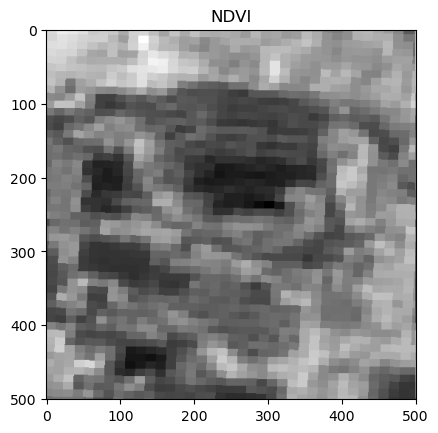

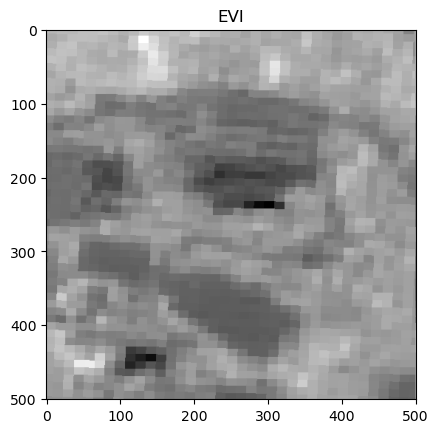

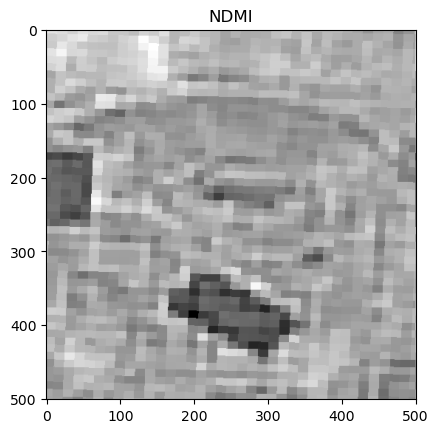

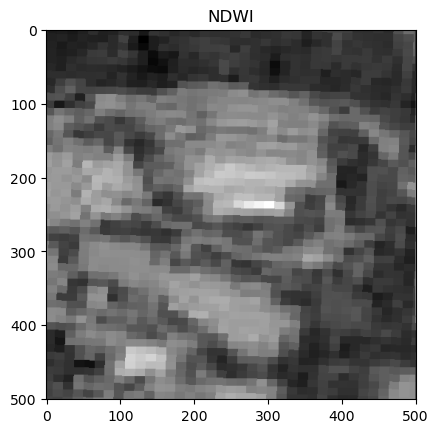

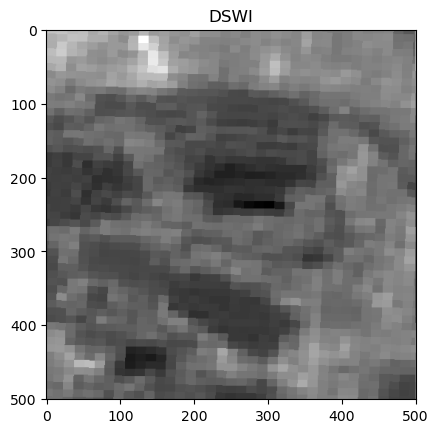

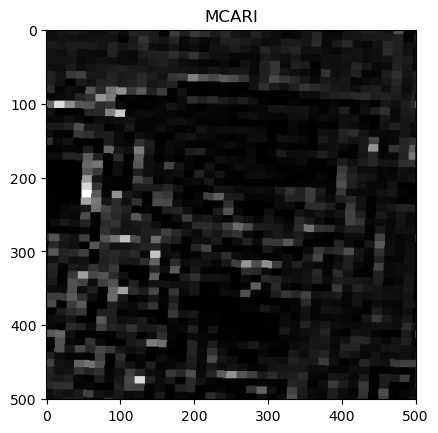

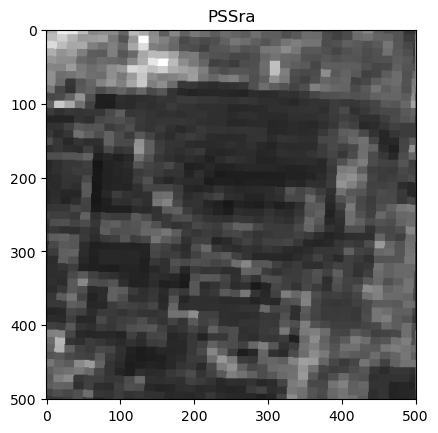

In [35]:
for _, funct in enumerate(im_array):
    plt.title(f'{funct}')
    plt.imshow(im_array.get(funct), 'gray')
    plt.show()

In [186]:
np.min(im_array.get('NDMI'))

-0.43929636

In [12]:
im_array.get('NDVI')

array([[0.39647725, 0.39647725, 0.58245206, ..., 0.2252148 , 0.2252148 ,
        0.        ],
       [0.39647725, 0.39647725, 0.58245206, ..., 0.2252148 , 0.2252148 ,
        0.39647725],
       [0.39647725, 0.39647725, 0.58245206, ..., 0.2252148 , 0.2252148 ,
        0.39647725],
       ...,
       [0.55671304, 0.55671304, 0.55671304, ..., 0.63094   , 0.63094   ,
        0.55671304],
       [0.55671304, 0.55671304, 0.55671304, ..., 0.63094   , 0.63094   ,
        0.55671304],
       [0.55671304, 0.55671304, 0.55671304, ..., 0.63094   , 0.63094   ,
        0.55671304]], dtype=float32)

In [14]:
np_arr = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [15]:
np_arr

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [78]:
to_mask = im_array.get('NDVI') < 0.3

In [79]:
mask_ndvi = np.ma.array(im_array.get('NDVI'), mask = to_mask)

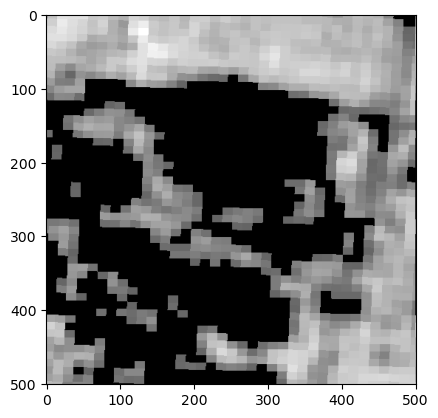

In [81]:
plt.imshow(mask_ndvi.filled(fill_value=0), 'gray')
plt.show()

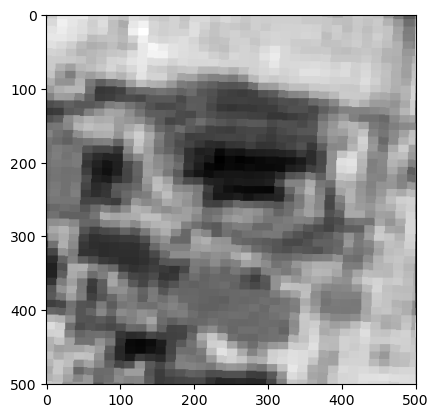

In [118]:
plt.imshow(np.sqrt(im_array.get('NDVI') + 0.5), 'gray')
plt.show()


In [120]:
im_array.get('NDVI')[220][250]

0.016148558